In [1]:
import os
import json
import pickle
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix as sparse_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

# Intro

We'll be using the [Amazon product data set](http://jmcauley.ucsd.edu/data/amazon/). The author of the data set has asked for the following citations:

> Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering.
> R. He, J. McAuley.
> WWW, 2016.
> 
> Image-based recommendations on styles and substitutes.
> J. McAuley, C. Targett, J. Shi, A. van den Hengel.
> SIGIR, 2015.

We will focus on the Patio, Lawn, and Garden section. Please download the [ratings](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Patio_Lawn_and_Garden.csv) and place them in the data directory with their default filenames. The code below should load the data:

In [2]:
filename = "/Users/arzan/MDS/ratings_Patio_Lawn_and_Garden.csv"

with open(os.path.join("data", filename), "rb") as f:
    ratings = pd.read_csv(f,names=("user","item","rating","timestamp"))
ratings.head()

,user,item,rating,timestamp
0,A2VNYWOPJ13AFP,0981850006,5.0,1259798400
1,A20DWVV8HML3AW,0981850006,5.0,1371081600
2,A3RVP3YBYYOPRH,0981850006,5.0,1257984000
3,A28XY55TP3Q90O,0981850006,5.0,1314144000
4,A3VZW1BGUQO0V3,0981850006,5.0,1308268800


We'd also like to construct the data matrix `X`. Let's see how big it would be:

In [3]:
def get_stats(ratings, item_key="item", user_key="user"):
    print("Number of ratings:", len(ratings))
    print("The average rating:", np.mean(ratings["rating"]))

    n = len(set(ratings[item_key]))
    d = len(set(ratings[user_key]))
    print("Number of users:", d)
    print("Number of items:", n)
    print("Fraction nonzero:", len(ratings)/(n*d))
    print("Size of full X matrix (GB):", (n*d)*8/1e9)

    return n,d

n,d = get_stats(ratings)

Number of ratings: 993490
The average rating: 4.006400668350965
Number of users: 714791
Number of items: 105984
Fraction nonzero: 1.3114269915944552e-05
Size of full X matrix (GB): 606.051274752


600 GB! That is way too big. We don't want to create that matrix. On the other hand, we see that we only have about 1 million ratings, which would be 8 MB or so ($10^6$ numbers $\times$ 8 bytes per number). Much more manageable. 

In [4]:
def create_X(ratings, n, d, user_key="user", item_key="item"):
    """
    Creates a sparse matrix using scipy.csr_matrix and mappers to relate indexes to items' id.
    
    Parameters:
    -----------
    ratings: the ratings to be stored in the matrix;
    n: the number of items
    d: the number of users
    user_key: the column in the pandas dataframe that contains the users id
    item_key: the column in the pandas dataframe that contains the items id
    
    Returns: (X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind)
    --------
    X: the sparse matrix containing the ratings. Note that
    user_mapper: stores the indexes of the users - the user_id is the key;
    item_mapper: stores the indexes of the items - the item_id is the key;
    user_inverse_mapper: stores the user id - the user index is the key;
    item_inverse_mapper: stores the item id - the item index is the key;
    user_ind: indexes of the users;
    item_ind: indexes of the items;
    """
    
    user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(d))))
    item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(n))))

    user_inverse_mapper = dict(zip(list(range(d)), np.unique(ratings[user_key])))
    item_inverse_mapper = dict(zip(list(range(n)), np.unique(ratings[item_key])))

    user_ind = [user_mapper[i] for i in ratings[user_key]]
    item_ind = [item_mapper[i] for i in ratings[item_key]]

    X = sparse_matrix((ratings["rating"], (item_ind, user_ind)), shape=(n,d))
    
    return X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind

X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind = create_X(ratings, n, d)

Note the shape of `X`: our rows are the products, and the columns (features) are the users. So, for each product, the ratings of all users forms the feature vector.

In [5]:
# sanity check
print(X.shape) # should be number of items by number of users
print(X.nnz)   # number of nonzero elements -- should equal number of ratings

(105984, 714791)
993490


In [6]:
X.data.nbytes

7947920

(Above: our calculation of 8 MB was right on. No surprises there.)

Let's aim to find the following items:

- the item with the most reviews
- the item with the most total stars
- the item with the lowest average stars

Then, find the names of these items by looking them up with the url https://www.amazon.com/dp/ITEM_ID, where `ITEM_ID` is the id of the item.

In [7]:
url_amazon = "https://www.amazon.com/dp/%s"

# example:
print(url_amazon % 'B00CFM0P7Y')

https://www.amazon.com/dp/B00CFM0P7Y


In [8]:
type(X)

scipy.sparse.csr.csr_matrix

In [9]:
def print_item_info(item):
    '''
    Function to print movie info
    '''
    print("Item index with most reviews is: {}".format(item))
    print("Link to the item:", url_amazon % item_inverse_mapper[item])
    print("Average rating: ", X[item].sum(axis = 1)/X[item].getnnz(axis = 1))

In [10]:
# getting the item with most reviews
item = np.argmax(X.getnnz(axis = 1))
print_item_info(item)
print("Name of the item: Classic Accessories 73942 Veranda Grill Cover, X-Large, Pebble")

Item index with most reviews is: 10959
Link to the item: https://www.amazon.com/dp/B000HCLLMM
Average rating:  [[4.54528302]]
Name of the item: Classic Accessories 73942 Veranda Grill Cover, X-Large, Pebble


In [11]:
# getting the item with most stars
item = np.argmax(X.sum(axis = 1))
print_item_info(item)
print("Name of the item: Classic Accessories 73942 Veranda Grill Cover, X-Large, Pebble")

Item index with most reviews is: 10959
Link to the item: https://www.amazon.com/dp/B000HCLLMM
Average rating:  [[4.54528302]]
Name of the item: Classic Accessories 73942 Veranda Grill Cover, X-Large, Pebble


In [12]:
# getting the item with lowest average
item = np.argmin(X.mean(axis = 1))
print_item_info(item)
print("Name of the item: 13ft Sycamore Wood Centre Pole Beige Umbrella Outdoor Patio Beach Market Garden")

Item index with most reviews is: 10
Link to the item: https://www.amazon.com/dp/6035000037
Average rating:  [[1.]]
Name of the item: 13ft Sycamore Wood Centre Pole Beige Umbrella Outdoor Patio Beach Market Garden


Make a histogram of the number of ratings per user and the number of ratings per item, and comment on the results. You use

```
plt.yscale('log', nonposy='clip')
``` 

to put the histogram on a log-scale.

In [13]:
X.shape

(105984, 714791)

In [14]:
# number of items
X.getnnz(axis = 1).shape

(105984,)

In [15]:
# number of users
X.getnnz(axis = 0).shape

(714791,)

In [16]:
def make_hist(X, axis, title=None):
    vals = X.getnnz(axis = axis)
    plt.hist(vals, bins=20)
    label = ""
    if axis == 1:
        label = "Item ratings"
    else:
        label = "User ratings"
    plt.xlabel(label)
    plt.ylabel("count")
    plt.yscale('log', nonposy='clip')
    plt.show()

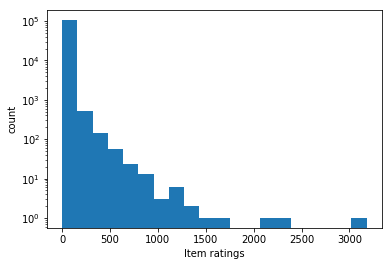

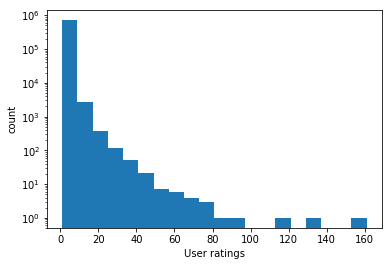

In [17]:
# histogram for item ratings
make_hist(X, 1)
# histogram for user ratings
make_hist(X, 0)

## Mr Grill

Use scikit-learn's [NearestNeighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) object (which uses Euclidean distance by default) to find the 5 items most similar to [MIGO PL-028-8, 8 Pack](https://www.amazon.com/dp/B00CFM0P7Y). 

(PS: two of these items are not in the Amazon website anymore)

Note: if you inspect the above URL, you'll see that the item ID is `B00CFM0P7Y`, which you'll need. The code block below grabs the row of `X` associated with the grill brush. The mappers take care of going back and forther between the IDs (like `B00CFM0P7Y`) and the indices of the sparse array (0,1,2,...).

In [18]:
grill_brush = "B00CFM0P7Y"
grill_brush_ind = item_mapper[grill_brush]
grill_brush_vec = X[grill_brush_ind]

In [19]:
def find_nearestneighbour(model, X, query_ind, show_ratings = False):
    model.fit(X)
    query_vec = X[query_ind]
    query_vec = query_vec.reshape(1, -1)
    query = model.kneighbors(query_vec, 6, return_distance=False)
    print("Indices of nearest neighbors:", query[0])
    for i in range(1, np.size(query[0])):
        ind = query[0][i]
        link = item_inverse_mapper[ind]
        if not show_ratings:
            print("Link to the item {}:".format(i), url_amazon % link)
        else:
            print("Link to the item {}:".format(i), url_amazon % link, \
                  "with total ratings: {}".format( X[query[0][i]].sum(axis = 1)))

In [20]:
neigh = NearestNeighbors(n_neighbors=5, metric="euclidean", n_jobs=-1)
find_nearestneighbour(neigh, X, grill_brush_ind)

Indices of nearest neighbors: [ 93652 103866 103865  98897  72226 102810]
Link to the item 1: https://www.amazon.com/dp/B00IJB5MCS
Link to the item 2: https://www.amazon.com/dp/B00IJB4MLA
Link to the item 3: https://www.amazon.com/dp/B00EXE4O42
Link to the item 4: https://www.amazon.com/dp/B00743MZCM
Link to the item 5: https://www.amazon.com/dp/B00HVXQY9A


> The last two items have been removed from Amazon.

## cosine similarity

Using cosine similarity instead of Euclidean distance in `NearestNeighbors`, find the 5 products most similar to `B00CFM0P7Y`.

In [21]:
# using cosine similarity

neigh = NearestNeighbors(n_neighbors=5, metric="cosine", n_jobs=-1)
find_nearestneighbour(neigh, X, grill_brush_ind)

Indices of nearest neighbors: [ 93652 103866 103867 103865  98068  98066]
Link to the item 1: https://www.amazon.com/dp/B00IJB5MCS
Link to the item 2: https://www.amazon.com/dp/B00IJB8F3G
Link to the item 3: https://www.amazon.com/dp/B00IJB4MLA
Link to the item 4: https://www.amazon.com/dp/B00EF45AHU
Link to the item 5: https://www.amazon.com/dp/B00EF3YF0Y


## Euclidean distance vs. cosine similarity

Let's now do the following to further understand our results
1. For each of the two metrics, compute the compute the total popularity (total stars) of each of the 5 items and report it. 
2. What's the difference between Euclidean distance vs. cosine similarity? 

In [22]:
# for euclidean case
neigh = NearestNeighbors(n_neighbors=5, metric="euclidean", n_jobs=-1)
find_nearestneighbour(neigh, X, grill_brush_ind, show_ratings = True)

Indices of nearest neighbors: [ 93652 103866 103865  98897  72226 102810]
Link to the item 1: https://www.amazon.com/dp/B00IJB5MCS with total ratings: [[266.]]
Link to the item 2: https://www.amazon.com/dp/B00IJB4MLA with total ratings: [[205.]]
Link to the item 3: https://www.amazon.com/dp/B00EXE4O42 with total ratings: [[5.]]
Link to the item 4: https://www.amazon.com/dp/B00743MZCM with total ratings: [[5.]]
Link to the item 5: https://www.amazon.com/dp/B00HVXQY9A with total ratings: [[5.]]


In [23]:
# for cosine case
neigh = NearestNeighbors(n_neighbors=5, metric="cosine", n_jobs=-1)
find_nearestneighbour(neigh, X, grill_brush_ind, show_ratings=True)

Indices of nearest neighbors: [ 93652 103866 103867 103865  98068  98066]
Link to the item 1: https://www.amazon.com/dp/B00IJB5MCS with total ratings: [[266.]]
Link to the item 2: https://www.amazon.com/dp/B00IJB8F3G with total ratings: [[438.]]
Link to the item 3: https://www.amazon.com/dp/B00IJB4MLA with total ratings: [[205.]]
Link to the item 4: https://www.amazon.com/dp/B00EF45AHU with total ratings: [[311.]]
Link to the item 5: https://www.amazon.com/dp/B00EF3YF0Y with total ratings: [[513.]]


> In high dimensions, most of the points seem to lie on a sphere and with `Cosine` similarity, we are obtaining items that are closer to each other in property as it uses the angles between the objects which make sense considering points lying on a sphere. With `Euclidean` similarity on the other hand, we get total ratings values which are not very close or similar to each other which makes sense because we are using a distance metric for calculating the neighbors and these distances might be similar for very dissimilar points lying in a high-dimensional space.

## Items with a reviewer in common

In all the above, our feature vectors are the vectors of all the user ratings for a given item. These features are quite sparse: from above we can see that only about $1$ in $100,000$ user-item combinations actually has a rating. As a result, when comparing two items we really don't have a lot of information. For example, what if two items have no users in common whatsoever? (Meaning, there does not exist a user that has rated both items). In this case, the cosine similarity between two such items would be zero, since the cosine similarity is just a normalized dot product, and each term in the dot product is zero (it's worth pondering this until you're sure you understand).

Given the above, we'd never connect two such items, although they may in reality be quite similar. For example, we might know item A is very similar to item B and that item B is very similar to item C, but not grasp the connection between A and C because they might not have any ratings in common.

Let's try to understand how often this happens.

We have $n$ items which means we have roughly $n^2$ pairs of items. Well, $n(n-1)/2$ to be exact.

In [24]:
num_pairs = n*(n-1)//2
num_pairs

5616251136

For all the ~5 billion pairs of items in our data set, let's find the fraction of them that have no users in common.

In [25]:
# I can get the number of zeros in X.T@X and that will give me the number of dot products that are 0
check_nz = X@X.T

# the total number of entries should be equal to (num_pairs * 2 + n)
# (as num_pairs = number of entries in the lower triangular matrix)

(check_nz.shape[0])**2 == num_pairs*2 + n

# checking non-zero entries in the matrix
print("Fraction of items with no users: {:.5f}".format(check_nz.getnnz(None) / (num_pairs*2 + n)))

Fraction of items with no users: 0.00014


> This is very low rate for the dot product being zero. I didn't expect this at first but it kind of makes sense as since we have so many items and users, the probability of getting a 0 dot product is very low (which we can see from the above number).

## Matrix completion with SVD

Let's run collaborative filtering on this data set. 

**Plan A**: we run PCA on the matrix, and then look at the reconstruction we get from PCA. The reconstruction will be dense, whereas the original matrix is sparse. We can then run nearest neighbours on this dense matrix and hope for better results. But, wait. Didn't we say above that the dense $n \times n$ matrix is way too big to deal with? Ok, let's try something slightly different. 

**Plan B**: PCA gives us an approximation

$$X \approx ZW$$

where $Z$ is a $n \times k$ matrix of "factor loadings" and $W$ is a $k \times d$ matrix of our principal components or "factors". (So we've actually got a [low-rank approximation](https://en.wikipedia.org/wiki/Low-rank_approximation) to our original matrix $X$).

Let's use a fairly small value of $k$, and then do our nearest neighbours on the $Z$ matrix. We can give this a shot with $k=10$ again using the NearestNeighbors class with Euclidean distance. You can use scikit-learn's [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) to perform the dimensionality reduction. (We want a truncated rather than full SVD since a full SVD would involve $n\times n$ matrices, which we've already established are too big to deal with. And then we'd only use the first $k$ rows of it anyway. So a full SVD would be both impossible and pointless.) 


In [26]:
X.shape

(105984, 714791)

In [27]:
svd = TruncatedSVD(n_components=10, n_iter=10, random_state=42)
svd.fit(X)
Z = svd.transform(X)
Z.shape

(105984, 10)

In [28]:
# for euclidean case
neigh = NearestNeighbors(n_neighbors=5, metric="euclidean", n_jobs=-1)
find_nearestneighbour(neigh, Z, grill_brush_ind)

Indices of nearest neighbors: [93652 13756 10620 31819 19540 27755]
Link to the item 1: https://www.amazon.com/dp/B000MVLB8W
Link to the item 2: https://www.amazon.com/dp/B000H1SJ8C
Link to the item 3: https://www.amazon.com/dp/B001VNC3Q4
Link to the item 4: https://www.amazon.com/dp/B000X9BNG8
Link to the item 5: https://www.amazon.com/dp/B001H1NG1Q


> Looking at the results, the transformation into a smaller dimension subspace to get a dense matrix and then using the nearest neighbors with euclidean metric seems to give a better result than what we got earlier with euclidean metric. The items seem to be similar and closely related (grill and outdoor cooking category).

# Movie recommendations



For this part of the notebook I'm gonna use the [MovieLens](https://grouplens.org/datasets/movielens/) dataset. We'll use the small version of the data set which you can download [here](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip). Please download it and put the unzipped directory in your `data` directory. The structure of the data is described in the [README](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) that comes with the data. 


The loading and parsing of the data is done for you below.

In [29]:
movie_ratings = pd.read_csv(os.path.join("/Users/arzan/MDS", "ml-latest-small", "ratings.csv"))
movie_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [30]:
movie_n, movie_d = get_stats(movie_ratings, user_key="userId", item_key="movieId")

Number of ratings: 100836
The average rating: 3.501556983616962
Number of users: 610
Number of items: 9724
Fraction nonzero: 0.016999683055613623
Size of full X matrix (GB): 0.04745312


In [31]:
movie_X, user_mapper, movie_mapper, user_inverse_mapper, movie_inverse_mapper, user_ind, \
movie_ind = create_X(movie_ratings, movie_n, movie_d, user_key="userId", item_key="movieId")

In [32]:
toy_story_ind = 0
toy_story_vec = movie_X[toy_story_ind]

In [33]:
# to look up titles
movie_info = pd.read_csv(os.path.join("/Users/arzan/MDS", "ml-latest-small", "movies.csv"),index_col=0)
movie_info.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


Instead of the MIGO PL-028-8, 8 Pack, let's instead use our "query item" as _Toy Story_, which is the first movie in the list (`movieId`=1). Like with Amazon, you can look up the recommended movies by looking at the `links.csv` file, which gives you the IMDB id of each movie, allowing you to form a URL of the form http://www.imdb.com/title/ttXXXXXXX/ where `XXXXXXX` is the movie's IMDB id. However, that extra work isn't really necessary here since we have a second table mapping `movieId` to movie title, so you can just grab the titles and print them out directly (see below).


In [34]:
# to look up links
movie_links = pd.read_csv(os.path.join("/Users/adityasharma/Desktop", \
                                       "ml-latest-small", "links.csv"), index_col=0, dtype={'imdbId': object})
movie_links.head()

,imdbId,tmdbId
movieId,,
1,0114709,862.0
2,0113497,8844.0
3,0113228,15602.0
4,0114885,31357.0
5,0113041,11862.0


In [35]:
url_imdb = "http://www.imdb.com/title/tt%s"

def print_movie_info(item):
    '''
    Function to print movie info
    '''
    print("Movie index is: {}".format(item))
    print("The movie details are: {}".format(movie_info[movie_info.index.values == movie_inverse_mapper[item]]))
    print("Link to the movie:", 
          url_imdb % movie_links[movie_info.index.values == movie_inverse_mapper[item]].loc[:, 'imdbId'].values[0])
    print("Average rating:", movie_X[item].sum(axis = 1)/movie_X[item].getnnz(axis = 1))

In [36]:
# getting the movie with most reviews
item = np.argmax(movie_X.getnnz(axis = 1))

print_movie_info(item)

Movie index is: 314
The movie details are:                        title                    genres
movieId                                               
356      Forrest Gump (1994)  Comedy|Drama|Romance|War
Link to the movie: http://www.imdb.com/title/tt0109830
Average rating: [[4.16413374]]


In [37]:
# getting the movie with most total stars
item = np.argmax(movie_X.sum(axis = 1))
print_movie_info(item)

Movie index is: 277
The movie details are:                                     title       genres
movieId                                               
318      Shawshank Redemption, The (1994)  Crime|Drama
Link to the movie: http://www.imdb.com/title/tt0111161
Average rating: [[4.42902208]]


In [38]:
# getting the movie with lowest average stars
item = np.argmin(movie_X.mean(axis = 1))
print_movie_info(item)

Movie index is: 2685
The movie details are:                 title   genres
movieId                       
3604     Gypsy (1962)  Musical
Link to the movie: http://www.imdb.com/title/tt0056048
Average rating: [[0.5]]


---------------

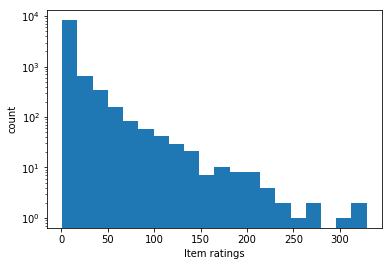

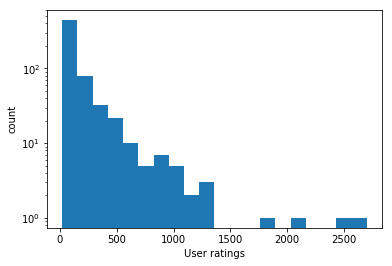

In [39]:
# function already there for histogram (directly calling)

# histogram for movie ratings
make_hist(movie_X, 1)
# histogram for user ratings
make_hist(movie_X, 0)

------


In [40]:
def find_nearestneighbour_imdb(model, X, query_ind, show_ratings = False):
    model.fit(X)
    query_vec = X[query_ind]
    query_vec = query_vec.reshape(1, -1)
    query = model.kneighbors(query_vec, 6, return_distance=False)
    print("Indices of nearest neighbors:", query[0])
    print("The nearest neighbors are: \n")
    for i in range(1, np.size(query[0])):
        ind = query[0][i]
        link = movie_links.iloc[ind]['imdbId']
        name = movie_info.iloc[ind]['title']
        if not show_ratings:
            print("{0}".format(name), url_imdb % link)
        else:
            print("{0}".format(name), url_imdb % link, \
                  "Total ratings: {}".format(X[query[0][i]].sum(axis = 1)))

In [41]:
# euclidean
neigh = NearestNeighbors(n_neighbors=5, metric="euclidean", n_jobs=-1)
find_nearestneighbour_imdb(neigh, movie_X, toy_story_ind)

Indices of nearest neighbors: [   0 2353  546  615 1756  622]
The nearest neighbors are: 

'night Mother (1986) http://www.imdb.com/title/tt0090556
Mission: Impossible (1996) http://www.imdb.com/title/tt0117060
Independence Day (a.k.a. ID4) (1996) http://www.imdb.com/title/tt0116629
Rugrats Movie, The (1998) http://www.imdb.com/title/tt0134067
Nutty Professor, The (1996) http://www.imdb.com/title/tt0117218


In [42]:
# cosine
neigh = NearestNeighbors(n_neighbors=5, metric="cosine", n_jobs=-1)
find_nearestneighbour_imdb(neigh, movie_X, toy_story_ind)

Indices of nearest neighbors: [   0 2353  418  615  224  314]
The nearest neighbors are: 

'night Mother (1986) http://www.imdb.com/title/tt0090556
Jurassic Park (1993) http://www.imdb.com/title/tt0107290
Independence Day (a.k.a. ID4) (1996) http://www.imdb.com/title/tt0116629
Star Wars: Episode IV - A New Hope (1977) http://www.imdb.com/title/tt0076759
Forrest Gump (1994) http://www.imdb.com/title/tt0109830


-----

In [43]:
# euclidean with total stars
neigh = NearestNeighbors(n_neighbors=5, metric="euclidean", n_jobs=-1)
find_nearestneighbour_imdb(neigh, movie_X, toy_story_ind, show_ratings=True)

Indices of nearest neighbors: [   0 2353  546  615 1756  622]
The nearest neighbors are: 

'night Mother (1986) http://www.imdb.com/title/tt0090556 Total ratings: [[374.5]]
Mission: Impossible (1996) http://www.imdb.com/title/tt0117060 Total ratings: [[573.]]
Independence Day (a.k.a. ID4) (1996) http://www.imdb.com/title/tt0116629 Total ratings: [[696.]]
Rugrats Movie, The (1998) http://www.imdb.com/title/tt0134067 Total ratings: [[323.5]]
Nutty Professor, The (1996) http://www.imdb.com/title/tt0117218 Total ratings: [[224.]]


In [44]:
# cosine with total stars
neigh = NearestNeighbors(n_neighbors=5, metric="cosine", n_jobs=-1)
find_nearestneighbour_imdb(neigh, movie_X, toy_story_ind, show_ratings=True)

Indices of nearest neighbors: [   0 2353  418  615  224  314]
The nearest neighbors are: 

'night Mother (1986) http://www.imdb.com/title/tt0090556 Total ratings: [[374.5]]
Jurassic Park (1993) http://www.imdb.com/title/tt0107290 Total ratings: [[892.5]]
Independence Day (a.k.a. ID4) (1996) http://www.imdb.com/title/tt0116629 Total ratings: [[696.]]
Star Wars: Episode IV - A New Hope (1977) http://www.imdb.com/title/tt0076759 Total ratings: [[1062.]]
Forrest Gump (1994) http://www.imdb.com/title/tt0109830 Total ratings: [[1370.]]


-----

In [45]:
# using transformation through SVD
svd = TruncatedSVD(n_components=10, n_iter=10, random_state=42)
svd.fit(movie_X)
Z = svd.transform(movie_X)

neigh = NearestNeighbors(n_neighbors=5, metric="euclidean", n_jobs=-1)
find_nearestneighbour_imdb(neigh, Z, toy_story_ind)

Indices of nearest neighbors: [  0 615 968 418 506 546]
The nearest neighbors are: 

Independence Day (a.k.a. ID4) (1996) http://www.imdb.com/title/tt0116629
Arsenic and Old Lace (1944) http://www.imdb.com/title/tt0036613
Jurassic Park (1993) http://www.imdb.com/title/tt0107290
Aladdin (1992) http://www.imdb.com/title/tt0103639
Mission: Impossible (1996) http://www.imdb.com/title/tt0117060


## Things that would be too slow with the Amazon dataset

1. Let's increase $k$ (the number of components of the SVD) and see what happens to the recommendations, as compared to the Euclidean nearest neighbour recommendations, when $k$ is large and try . to explain this result mathematically.
2. Something we can do with the SVD that we can't do with nearest neighbours is to predict missing ratings. For example, user 5 has not rated Toy Story. We can use the SVD to predict this rating, using the `inverse_transform` function of the `TruncatedSVD` class. 
3. Because of the size of the amazon data, the process in step is extremely slow. The problem is unavoidable if we want to predict all the missing ratings. However, if we really did just want to predict a single rating we could do that. 

In [46]:
# increasing k with SVD
for k in range(20, 600, 200):
    print("K = {}".format(k))
    svd = TruncatedSVD(n_components=k, n_iter=10, random_state=42)
    svd.fit(movie_X)
    Z = svd.transform(movie_X)

    neigh = NearestNeighbors(n_neighbors=5, metric="euclidean", n_jobs=-1)
    find_nearestneighbour_imdb(neigh, Z, toy_story_ind)
    print("-----------------------------------------")

K = 20
Indices of nearest neighbors: [  0 506 968 963 418 815]
The nearest neighbors are: 

Aladdin (1992) http://www.imdb.com/title/tt0103639
Arsenic and Old Lace (1944) http://www.imdb.com/title/tt0036613
Diva (1981) http://www.imdb.com/title/tt0082269
Jurassic Park (1993) http://www.imdb.com/title/tt0107290
Willy Wonka & the Chocolate Factory (1971) http://www.imdb.com/title/tt0067992
-----------------------------------------
K = 220
Indices of nearest neighbors: [   0 2353  615  546   32  325]
The nearest neighbors are: 

'night Mother (1986) http://www.imdb.com/title/tt0090556
Independence Day (a.k.a. ID4) (1996) http://www.imdb.com/title/tt0116629
Mission: Impossible (1996) http://www.imdb.com/title/tt0117060
Babe (1995) http://www.imdb.com/title/tt0112431
Mask, The (1994) http://www.imdb.com/title/tt0110475
-----------------------------------------
K = 420
Indices of nearest neighbors: [   0 2353  546  615  622 1756]
The nearest neighbors are: 

'night Mother (1986) http://www.i

> We see that the recommendations on increasing $k$ for SVD become close to what the actual recommendations are which can be measured by checking the example given for user 5 and toy story. This makes sense as we are trying to learn a low dimensional representation with SVD and on increasing $k$, we are learning the same information in more dimensions and the algorithm tries to incorporate the contribution of many reconstructed dimensions.

In [47]:
# transforming to a new dimension representation
print("getting original rating:")
print(movie_X[0, 4])
for n in [200, 300, 400]:
    svd = TruncatedSVD(n_components=n, n_iter=10, random_state=12345)
    svd.fit(movie_X)
    Z = svd.transform(movie_X)
    movie_new = svd.inverse_transform(Z)
    Z.shape

    print("getting constructed rating for user 5 for toy story, k = {}:". format(n))
    print(movie_new[0, 4])

getting original rating:
4.0
getting constructed rating for user 5 for toy story, k = 200:
2.413488464104162
getting constructed rating for user 5 for toy story, k = 300:
3.3472874523990916
getting constructed rating for user 5 for toy story, k = 400:
3.9871429092584494


The above example shows that the reconstruction is better with increasing $k$.

**3.** The amazon data is very huge and it would require a lot of time go through this process for such a large dataset. Let us try to do it for a single user and item:

In [48]:
sub_X = X[0:10, :]
svd = TruncatedSVD(n_components=200, n_iter=10, random_state=12345)
svd.fit(sub_X)
Z = svd.transform(sub_X)
movie_new = svd.inverse_transform(Z)
Z.shape

(10, 10)

In [49]:
# reconstructed rating
movie_new[9,4]

-1.4316688435111548e-18

# Brain Tease

For each of the following methods, let's understand how it might be applied to the problem of item recommendation:

1. Clustering
2. Graphs and breadth-first search


1. **Clustering**: For item recommendation, we could cluster items closer to each other in the feature space as having similar properties which is what we do above with euclidean distance. If we cluster the items after proper transformation, we will get meaningful clusters that will have some common property like how we found after using dimensionality reduction using SVD with euclidean distance for the amazon dataset.

2. **Graphs and breadth-first search**: If we try to use graph algorithms such as BFS, we can star with one item in the feature space and decide a fixed depth $d$ until which we will consider items as similar to the original item. Now performing BFS, all the items within a distance less than or equal to this number $d$ will be considered similar and can be recommended to the users that liked/rated high items falling in this group.

## Are we creating a bubble?
We've been using similarity as a proxy for things we want to recommend. However, this has its own disadvantages.

> Recommending similar items is often a good idea but not always the best strategy to tackle market growth. People might get bored of similar items/movies/products etc. and it would be good to recommend something new and different once in a while so that people get to try new things. This would keep them interested in what the algorithm/company has to offer to them and would lead to more user engagement overall. For example, if a user watched Harry Potter 1, it would be a good idea to not just recommend all the HP series and instead provide some different fantasy options as well like Lord of the Rings, etc.

## Alternative ways to recommend

Another way to recommend items, say movies on Netflix, is to use something like the SVD to fill in the missing entries, and then for each user take the movies for which the predicted ratings is highest. In other words, I'll recommend the movies that I think you'll rate highly.


> Using this approach, we are trying to learn patterns from the data and trying to represent them in lower dimensions where we don't have missing values. Therefore, this approach is making the use of what the algorithm thinks are similar items. An approach using nearest neighbors on the other hand, depends on other people ratings for the similarity measure. In this case, we will rate items as similar if people with similar item choices have rated those items with similar ratings. So both the approaches differ in their sources of obtaining the missing values of the ratings. Use cases would depend on the size of the data. More items and users would lead to higher dimensions where SVD would give better results. But in cases with smaller dimensions and when we want to recommend based on similar users and their choices, we could go for nearest neighbors. I think the better approach is to find a lower $k$-dimensional representation of the original data which best reconstructs the original data using SVD. This is better than finding clusters in high dimensions which might not give reliable results with distance metrics as a measure of similarity.